# Wave with periodic bc with the scheme from Palma

We solve the wave equation with Dirichlet boundary conditions (homogeneous) up to $T = 2L$ where $L$ is the space size of the integrating region. The data is reflection symmetric, $u_0(x) = u_0(L-x)$, $\partial_t u(x,t=0) = 0$. This way at the last point the solution repeats itself and we can measure the error very well.

In [1]:
import Pkg
#Pkg.add("Zygote")
#Pkg.instantiate()
#Pkg.add("StatsBase")
#Pkg.add("UnPack")
#Pkg.add("Revise")
using ComponentArrays
using Distributions
#using WGLMakie
using Lux
using LuxCUDA
using Optim
using OptimizationOptimJL
using Random
using UnPack
using Zygote
#using CairoMakie  # Backend que funciona en notebooks
using StatsBase
using Revise
using Plots
using JLD2
using NBInclude
#import NaNMath

## Status:

Working well in both GPU and CPU without adaptivity. Using both initial data for u and its derivative.

I put some functions here.

In [2]:
includet("../../neural_tools.jl")
includet("config.jl")

In [3]:

config = config_basic
#config = config_test  # switch to config for real run

@show get_parameter_count(config)


get_parameter_count(config) = 1341


1341

**Note 1:** I attempted to put a bump function of compact support (with some if's) and could not make it run. It seems there are problems with the AD scheme to handle if's. So I put a simpler function.

**Note 2:** As it is, with adaptive it takes 12 hours (CPU) to run... And the solution is wrong...

In [4]:
# -------------------------------------------------------------------
# Second order wave equation (onda 1D): u_tt - c^2 u_xx = 0
# -------------------------------------------------------------------

function wave_equation(∂2u_∂x2, ∂2u_∂t2, config) 
    c = config[:c]
    ∂2u_∂t2 .- (c^2) .* ∂2u_∂x2
end

```
Residual at collocation points
``` 

function residual_at_points_Dirichlet(input, NN, Θ, st)
    x, t = input[1:1, :], input[2:2, :]
    _, u_xx, u_tt = calculate_derivatives_Dirichlet(x, t, NN, Θ, st)
    res = wave_equation(u_xx, u_tt, config) 
    abs_res = (abs.(u_xx) .+ abs.(u_tt))
    res = res ./ abs_res
    #res = wave_equation(u_xx, u_tt, config)
    #return vec(abs.(res |> cpu_device()))  # magnitud del residuo en CPU
    #return vec(abs.(res))
    return res
end


# -------------------------------------------------------------------
# Loss function with Dirichlet boundary conditions hard enforced.
# -------------------------------------------------------------------

function loss_function(input, NN, Θ, st)
    res = residual_at_points_Dirichlet(input[1], NN, Θ, st)
    #return log10(sum(abs2, res) / length(res))
    #return log10(sum(abs, res) / length(res))
    return sum(abs, res) / length(res)
end

# -------------------------------------------------------------------
# Callback
# -------------------------------------------------------------------
function callback(p, l, losses)
    println("Current loss: ", l)
    push!(losses, log10(l))
    return false
end

callback (generic function with 1 method)

In [5]:
#loss_function(input_total, NN, Θ, st)

Initial data:

In [6]:
includet("wave_ini_bound_data.jl")

#plot(u0, xmin, xmax, title="Initial displacement u0(x) and velocity u1(x)", xlabel="x", ylabel="u0/u1", label="u0")
#plot!(u1, xmin, xmax, label="u1")

### Results:

1. With the p=4 polynomial data works OK and the error is of low frequency.
2. With the p=2 sin data it does not work. Start decreasing the loss function but at some point there is a problem with the optimizer and it does not improve further, on the contrary the loss stabilizes in a larger value.
It seems to be going with smaller t evolution (as if the speed were smaller)
3. We tried with rescaling the residual by the norm of the derivatives, but it does not work with SSB nor with the log10 transformation. It works very slowly with BB. 

In [7]:
input = generate_input_x_t(config)
input0 = generate_input0_x(config)
input_bound = generate_input_boundary_x(config)
input_total = [input, input0, input_bound]

@show typeof(input_total) size(input_total)
@show get_parameter_count(config)

#input_cpu = input |> cpu_device()

# plot the inputs is needed
#scatter(input_cpu[1,:], input_cpu[2,:], markersize=1, title="Collocation points", xlabel="x", ylabel="t")

typeof(input_total) = Vector{CuArray{Float64, N, CUDA.DeviceMemory} where N}
size(input_total) = (3,)
get_parameter_count(config) = 1341


1341

In [8]:
# -------------------------------------------------------------------
# Entrenamiento
# -------------------------------------------------------------------
losses = []
NN, Θ, st = create_neural_network(config)


#input_total[1] === input

(Chain{@NamedTuple{layer_1::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_4::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_5::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}((layer_1 = Dense(2 => 20, tanh), layer_2 = Dense(20 => 20, tanh), layer_3 = Dense(20 => 20, tanh), layer_4 = Dense(20 => 20, tanh), layer_5 = Dense(20 => 1)), nothing), (layer_1 = (weight = [-1.8471219539642334 1.11846125125885; -0.8797334432601929 0.2494577318429947; … ; 1.5016003847122192 -0.32814761996269226; 0.9525068998336792 -1.1490586996078491], bias = [-0.6122202277183533, -0.6678104996681213, -0.5230600237846375, 0.1281595528125763, 0.13647562265396118, 0.571537971496582, 0.015267611481249332, 0.38651853799819946, 0.5321496725082397, -0.07222519814968109, 0.5314704775810242, 0

In [9]:
#res = residual_at_points_Dirichlet(input_total[1], NN, Θ, st)
#res_cpu = res |> cpu_device()
#@show typeof(res_cpu) size(res_cpu)
#res_cpu

In [10]:
loss_function(input_total, NN, Θ, st)

0.9998808431260848

In [11]:


#calculate_Dirichlet_f(input[1:1, :], input[2:2, :], NN, Θ, st)
#f, ∂2f_∂x2, ∂2f_∂t2 = calculate_derivatives_Dirichlet(input[1:1, :], input[2:2, :], NN, Θ, st)

In [11]:
Θ, st, losses = compute_solution_1d(config, input_total, NN, Θ, st, losses)
# Parámetros optimizados a CPU si procede


 

┌ Info: Normal training round 1 / 40  |  iters=1000
└ @ Main /users/oreula/Julia/PINN/neural_tools.jl:481


Current loss: 0.9998808431260848
Current loss: 0.9971715213424147
Current loss: 0.9957942718246978
Current loss: 0.9957908650008664
Current loss: 0.9957790381647349
Current loss: 0.995742008620823
Current loss: 0.9955168072104461
Current loss: 0.9954543554287278
Current loss: 0.9945608594312673
Current loss: 0.9891740241891791
Current loss: 0.9849823805126443
Current loss: 0.9849702347713908
Current loss: 0.9846543192128369
Current loss: 0.9227267413710016
Current loss: 0.9216132593639264
Current loss: 0.9215080036726326
Current loss: 0.8586608157857599
Current loss: 0.8477003543544379
Current loss: 0.8403122684996369
Current loss: 0.840308672690921
Current loss: 0.8403085676886781
Current loss: 0.8403051367302673
Current loss: 0.7937919242846146
Current loss: 0.7924814596956163
Current loss: 0.7913163282114406
Current loss: 0.7911904124887483
Current loss: 0.7911632607676353
Current loss: 0.787796472991185
Current loss: 0.7866840048349071
Current loss: 0.7865030785357123
Current loss:

┌ Info: Normal training round 2 / 40  |  iters=1000
└ @ Main /users/oreula/Julia/PINN/neural_tools.jl:481



Current loss: 0.41773318968202205
Current loss: 0.4164111099755066
Current loss: 0.4073234482833481
Current loss: 0.4002275608408067
Current loss: 0.39677066406525546
Current loss: 0.3950518825585037
Current loss: 0.3948504074557085
Current loss: 0.39463954178490124
Current loss: 0.3938173737497019
Current loss: 0.3927294348381073
Current loss: 0.39272909412002743
Current loss: 0.39218963485297853
Current loss: 0.3910755593326796
Current loss: 0.39102734119534643
Current loss: 0.3907193382181067
Current loss: 0.3905925317657395
Current loss: 0.39013876620409577
Current loss: 0.38980874925964265
Current loss: 0.38915949522956655
Current loss: 0.38896479976142495
Current loss: 0.3883298704739008
Current loss: 0.38812064624728093
Current loss: 0.38213302470734734
Current loss: 0.38194939151875124
Current loss: 0.3797484104115052
Current loss: 0.37962318657038213
Current loss: 0.37703632337390525
Current loss: 0.37599667255561003
Current loss: 0.3756985693507218
Current loss: 0.3748954300

┌ Info: Normal training round 3 / 40  |  iters=1000
└ @ Main /users/oreula/Julia/PINN/neural_tools.jl:481


Current loss: 0.342313133504776
Current loss: 0.342040462964349
Current loss: 0.34109699035869884
Current loss: 0.3409555483588703
Current loss: 0.3406000683560321
Current loss: 0.3405213559589074
Current loss: 0.3405171300326734
Current loss: 0.3404947994519765
Current loss: 0.33982979036660615
Current loss: 0.3397219294278641
Current loss: 0.3393607160000106
Current loss: 0.33934346387808745
Current loss: 0.33613817134999524
Current loss: 0.33608230728028066
Current loss: 0.3357582002897944
Current loss: 0.3350074077802203
Current loss: 0.3349076967421991
Current loss: 0.3332212059687145
Current loss: 0.33315323236307653
Current loss: 0.33191044680735615
Current loss: 0.33162243602477837
Current loss: 0.33140858751786584
Current loss: 0.3310929375520021
Current loss: 0.3309500326101135
Current loss: 0.330259565842312
Current loss: 0.3299106476869359
Current loss: 0.3297953964986158
Current loss: 0.32939149817840735
Current loss: 0.32924902766284564
Current loss: 0.3283582092071604
Cu

┌ Info: Normal training round 4 / 40  |  iters=1000
└ @ Main /users/oreula/Julia/PINN/neural_tools.jl:481


Current loss: 0.3361121068300514
Current loss: 0.3350543062148126
Current loss: 0.3343430483360754
Current loss: 0.3307081325774251
Current loss: 0.33036457216001963
Current loss: 0.3303467825455622
Current loss: 0.33033356391208224
Current loss: 0.3281282620952997
Current loss: 0.327762308364502
Current loss: 0.32769977475428097
Current loss: 0.3241744203506013
Current loss: 0.32265210881036943
Current loss: 0.3225787120424373
Current loss: 0.32037906807250316
Current loss: 0.3202528917954194
Current loss: 0.3177269060073642
Current loss: 0.31722241908999627
Current loss: 0.3169144905659824
Current loss: 0.3144129772961694
Current loss: 0.3098290400952518
Current loss: 0.3088268153255514
Current loss: 0.30823091663378244
Current loss: 0.30690413265239597
Current loss: 0.3067194349191381
Current loss: 0.3059425680391433
Current loss: 0.305032698700458
Current loss: 0.3047592333074846
Current loss: 0.3038591261751583
Current loss: 0.30369822357226445
Current loss: 0.3036728289242024
Cur

┌ Info: Normal training round 5 / 40  |  iters=1000
└ @ Main /users/oreula/Julia/PINN/neural_tools.jl:481


Current loss: 0.32056616183347003
Current loss: 0.31804485723805015
Current loss: 0.3180181563433986
Current loss: 0.31798878728996166
Current loss: 0.3155916515070959
Current loss: 0.31540217909520024
Current loss: 0.3153937102028898
Current loss: 0.3150437780186553
Current loss: 0.31389057667553166
Current loss: 0.3135929783329081
Current loss: 0.31154805939464086
Current loss: 0.3111368976155255
Current loss: 0.31095030403058893
Current loss: 0.31070334712552933
Current loss: 0.31068530922154586
Current loss: 0.31062073686041525
Current loss: 0.31043529580451706
Current loss: 0.31029391560065506
Current loss: 0.3101436891155065
Current loss: 0.3098601930458376
Current loss: 0.3095387078787388
Current loss: 0.30920645999210344
Current loss: 0.30888174150983705
Current loss: 0.3085070803457032
Current loss: 0.3083842512795925
Current loss: 0.30784710358774037
Current loss: 0.3077075275711467
Current loss: 0.3071556411281904
Current loss: 0.3068883375219634
Current loss: 0.305830661489

┌ Info: Normal training round 6 / 40  |  iters=1000
└ @ Main /users/oreula/Julia/PINN/neural_tools.jl:481


Current loss: 0.3060887446610956
Current loss: 0.3057438764135961
Current loss: 0.30342943765805286
Current loss: 0.3025896223779489
Current loss: 0.30127851181822535
Current loss: 0.30126472801150317
Current loss: 0.3010119810968373
Current loss: 0.30098605547438423
Current loss: 0.3004336288635575
Current loss: 0.30006271876696244
Current loss: 0.2996339485264043
Current loss: 0.29958754392649595
Current loss: 0.2994740998923809
Current loss: 0.299368139476864
Current loss: 0.29826355286563355
Current loss: 0.2979880425666493
Current loss: 0.2976271562013296
Current loss: 0.2973024261156689
Current loss: 0.29699009434409507
Current loss: 0.2969090207849322
Current loss: 0.2966817647580301
Current loss: 0.2961047949922744
Current loss: 0.29596894233222193
Current loss: 0.2957320769283225
Current loss: 0.2955617759588022
Current loss: 0.2950557015485865
Current loss: 0.2949800864079377
Current loss: 0.2948672551773008
Current loss: 0.2945503695795932
Current loss: 0.294452879989664
Cur

┌ Info: Normal training round 7 / 40  |  iters=1000
└ @ Main /users/oreula/Julia/PINN/neural_tools.jl:481


Current loss: 0.3073483346728797
Current loss: 0.30620440851821745
Current loss: 0.3061280804897145
Current loss: 0.3044881821479473
Current loss: 0.30350632675577593
Current loss: 0.3030375492249187
Current loss: 0.30241893512329715
Current loss: 0.30239138433190044
Current loss: 0.29968968077258085
Current loss: 0.2977386342364808
Current loss: 0.29663457462061743
Current loss: 0.2965562986119706
Current loss: 0.29290988932291234
Current loss: 0.29287968420155996
Current loss: 0.2921117648017545
Current loss: 0.29130841994127993
Current loss: 0.2911787821044667
Current loss: 0.29094355651661796
Current loss: 0.2908349180176263
Current loss: 0.29073286788499414
Current loss: 0.2896787180919412
Current loss: 0.28949988261989446
Current loss: 0.28922930776310873
Current loss: 0.2884795532943998
Current loss: 0.2880637037191851
Current loss: 0.2879575159717372
Current loss: 0.28758156884058406
Current loss: 0.2874590517153334
Current loss: 0.287403961623662
Current loss: 0.28716697224340

┌ Info: Normal training round 8 / 40  |  iters=1000
└ @ Main /users/oreula/Julia/PINN/neural_tools.jl:481


Current loss: 0.30193361285496073
Current loss: 0.3001402108005692
Current loss: 0.2973602908058944
Current loss: 0.29708715591724677
Current loss: 0.2968915718990593
Current loss: 0.29677046932036966
Current loss: 0.2941538209822205
Current loss: 0.294118591458692
Current loss: 0.2940845297323139
Current loss: 0.294035686379327
Current loss: 0.2940202489653216
Current loss: 0.2938966947211861
Current loss: 0.29341469110794843
Current loss: 0.2931954728886358
Current loss: 0.2931911399504563
Current loss: 0.2927285584738582
Current loss: 0.29271193327418416
Current loss: 0.29087756398874887
Current loss: 0.29061412470893944
Current loss: 0.28965744747918254
Current loss: 0.2893640441026278
Current loss: 0.2889172406737394
Current loss: 0.28850458158827486
Current loss: 0.28700968329961196
Current loss: 0.28680720979907337
Current loss: 0.2867419112278972
Current loss: 0.28631407549880405
Current loss: 0.28609831751002573
Current loss: 0.2853778790657301
Current loss: 0.2849789920075522

┌ Info: Normal training round 9 / 40  |  iters=1000
└ @ Main /users/oreula/Julia/PINN/neural_tools.jl:481


Current loss: 0.2983986585782015
Current loss: 0.2978238455895098
Current loss: 0.2973930094709784
Current loss: 0.2970966526768019
Current loss: 0.2970901480925646
Current loss: 0.2968505529233666
Current loss: 0.29515610878726783
Current loss: 0.2951304266034391
Current loss: 0.29508603000103006
Current loss: 0.2948690609496336
Current loss: 0.29486019105279104
Current loss: 0.2947638707387346
Current loss: 0.2944476497540978
Current loss: 0.29441319461073057
Current loss: 0.2944080690829182
Current loss: 0.29439038784655863
Current loss: 0.29280836807722144
Current loss: 0.29279865456842485
Current loss: 0.2927010138071174
Current loss: 0.2922766776617569
Current loss: 0.29223754069676744
Current loss: 0.2918689592910175
Current loss: 0.29105578149286804
Current loss: 0.29088037802716565
Current loss: 0.2906825373723469
Current loss: 0.29007253211166334
Current loss: 0.28977372137178614
Current loss: 0.2891998104175791
Current loss: 0.2885473961635643
Current loss: 0.288464800441193

┌ Info: Normal training round 10 / 40  |  iters=1000
└ @ Main /users/oreula/Julia/PINN/neural_tools.jl:481


Current loss: 0.30860710717342793
Current loss: 0.30856720872590965
Current loss: 0.30840346899640536
Current loss: 0.3083867033335168
Current loss: 0.30836703061233856
Current loss: 0.30833021797772364
Current loss: 0.30823752991687203
Current loss: 0.3079650084425018
Current loss: 0.30788645093780054
Current loss: 0.3073657777859012
Current loss: 0.3073627090107605
Current loss: 0.3063513325194295
Current loss: 0.3062441711488313
Current loss: 0.3017519508142485
Current loss: 0.3010923973976732
Current loss: 0.3007619284416058
Current loss: 0.29961650581610116
Current loss: 0.2989368141972835
Current loss: 0.29843705418521815
Current loss: 0.2983618364195447
Current loss: 0.29783027675639934
Current loss: 0.2977607959673354
Current loss: 0.297532998892353
Current loss: 0.2973139231806543
Current loss: 0.29729297569941104
Current loss: 0.2969908309407309
Current loss: 0.2969196439512845
Current loss: 0.29669714779985473
Current loss: 0.2964409265721606
Current loss: 0.2963432169454454

┌ Info: Normal training round 11 / 40  |  iters=1000
└ @ Main /users/oreula/Julia/PINN/neural_tools.jl:481


Current loss: 0.30233933178109385
Current loss: 0.3019565707992246
Current loss: 0.3019257903708674
Current loss: 0.3014953073650423
Current loss: 0.30126174612103934
Current loss: 0.30116969040533953
Current loss: 0.3010772132760098
Current loss: 0.2995604129431887
Current loss: 0.29955018555212964
Current loss: 0.29859330128348605
Current loss: 0.2983726391936092
Current loss: 0.2982422132410551
Current loss: 0.2975419512473616
Current loss: 0.2971434519486679
Current loss: 0.29706555507834126
Current loss: 0.29683520466477303
Current loss: 0.29641436918125474
Current loss: 0.29607347530789163
Current loss: 0.2960440152250327
Current loss: 0.295973211679662
Current loss: 0.29569464920365357
Current loss: 0.2955795572598382
Current loss: 0.29541602430853015
Current loss: 0.29539252100437535
Current loss: 0.2952348542468749
Current loss: 0.2951225110807088
Current loss: 0.29505087021439147
Current loss: 0.29499440956973794
Current loss: 0.29494267741813507
Current loss: 0.2949170713942

┌ Info: Normal training round 12 / 40  |  iters=1000
└ @ Main /users/oreula/Julia/PINN/neural_tools.jl:481


Current loss: 0.3079754890619689
Current loss: 0.3079366919614481
Current loss: 0.3075370348958411
Current loss: 0.3073772297631323
Current loss: 0.30736701898127106
Current loss: 0.3065584940078929
Current loss: 0.3065519555818835
Current loss: 0.3048696705329503
Current loss: 0.30367864762621405
Current loss: 0.3030106669722204
Current loss: 0.30290721860918823
Current loss: 0.3022457017169348
Current loss: 0.30191340823401286
Current loss: 0.3018275703937641
Current loss: 0.30157995383845126
Current loss: 0.3013987361018602
Current loss: 0.30029152789529134
Current loss: 0.29993021871687325
Current loss: 0.29984862339751545
Current loss: 0.2990311148508226
Current loss: 0.29877089233087645
Current loss: 0.2985348104865358
Current loss: 0.298426463230198
Current loss: 0.2981438806967352
Current loss: 0.2980156774013358
Current loss: 0.2978943517371653
Current loss: 0.29786129577540277
Current loss: 0.297809560260814
Current loss: 0.29777406947749074
Current loss: 0.2976603726659921
C

┌ Info: Normal training round 13 / 40  |  iters=1000
└ @ Main /users/oreula/Julia/PINN/neural_tools.jl:481



Current loss: 0.28769319414990946
Current loss: 0.28752234674059574
Current loss: 0.28751043682285604
Current loss: 0.2872861148328156
Current loss: 0.2872311610881182
Current loss: 0.28709611532911544
Current loss: 0.2869852746037882
Current loss: 0.2864934330030735
Current loss: 0.28626745712695983
Current loss: 0.2862215405952067
Current loss: 0.2832249556759358
Current loss: 0.2831973242794195
Current loss: 0.28286626862432207
Current loss: 0.2809114405227839
Current loss: 0.2801559105226172
Current loss: 0.2797216980265375
Current loss: 0.27899108919571963
Current loss: 0.2783738803071782
Current loss: 0.2782386940280752
Current loss: 0.278213812281934
Current loss: 0.27785872161104364
Current loss: 0.27765872918984613
Current loss: 0.2776024953768631
Current loss: 0.276501761510118
Current loss: 0.2764209027160099
Current loss: 0.27634497786841666
Current loss: 0.27624338467455595
Current loss: 0.27561967921656233
Current loss: 0.27549513310728013
Current loss: 0.275393418419342

┌ Info: Normal training round 14 / 40  |  iters=1000
└ @ Main /users/oreula/Julia/PINN/neural_tools.jl:481


Current loss: 0.28378746905152064
Current loss: 0.28355008608104226
Current loss: 0.2807011775503106
Current loss: 0.27941135378004545
Current loss: 0.27878237729800553
Current loss: 0.2787659190750273
Current loss: 0.27641019781624654
Current loss: 0.2763236299652403
Current loss: 0.27627977412956795
Current loss: 0.2761832358104157
Current loss: 0.27554682221049437
Current loss: 0.275410132949006
Current loss: 0.27530432559438706
Current loss: 0.27499303329028035
Current loss: 0.27474196156059194
Current loss: 0.2747039150840517
Current loss: 0.27461498205228413
Current loss: 0.27436541697503336
Current loss: 0.2740933699907774
Current loss: 0.2739521630717556
Current loss: 0.27380628858046335
Current loss: 0.27347859000302016
Current loss: 0.27254183750632843
Current loss: 0.27207891275020335
Current loss: 0.27128658662238875
Current loss: 0.2709459226321725
Current loss: 0.2709340648703457
Current loss: 0.27082019728131257
Current loss: 0.27046184249592553
Current loss: 0.270293790

┌ Info: Normal training round 15 / 40  |  iters=1000
└ @ Main /users/oreula/Julia/PINN/neural_tools.jl:481


Current loss: 0.297934738715776
Current loss: 0.2957780394438265
Current loss: 0.2957601829810052
Current loss: 0.2957403565525452
Current loss: 0.2951900199309758
Current loss: 0.29516919044807693
Current loss: 0.2951581097845379
Current loss: 0.29507154180268846
Current loss: 0.2950449775478319
Current loss: 0.2937769639754271
Current loss: 0.29367798355087643
Current loss: 0.29149023981672223
Current loss: 0.2900209093707059
Current loss: 0.2896973288628839
Current loss: 0.28960441353869587
Current loss: 0.2893993004088748
Current loss: 0.2889529840643643
Current loss: 0.28891136303545506
Current loss: 0.28814705718751127
Current loss: 0.2851239766080164
Current loss: 0.2848406477154271
Current loss: 0.28480191135034477
Current loss: 0.2845002126210462
Current loss: 0.28440114303893965
Current loss: 0.28428265386440554
Current loss: 0.28419078883959137
Current loss: 0.28393278371620123
Current loss: 0.283768322309859
Current loss: 0.2833867781323929
Current loss: 0.2831211464443391


┌ Info: Normal training round 16 / 40  |  iters=1000
└ @ Main /users/oreula/Julia/PINN/neural_tools.jl:481


Current loss: 0.2937004991260434
Current loss: 0.2925799990778318
Current loss: 0.2923195036586955
Current loss: 0.29147576161619976
Current loss: 0.29117770433736007
Current loss: 0.2903060036156972
Current loss: 0.2902450756616635
Current loss: 0.28901217647589805
Current loss: 0.2882584518216778
Current loss: 0.28791935281934095
Current loss: 0.28675038333598096
Current loss: 0.28664402079717294
Current loss: 0.28617423803863845
Current loss: 0.2861381837997782
Current loss: 0.28577780378449436
Current loss: 0.28573261340235234
Current loss: 0.28517305410879856
Current loss: 0.28506763147587943
Current loss: 0.2849157278597479
Current loss: 0.2846941504000598
Current loss: 0.2843843271579559
Current loss: 0.28407124280952595
Current loss: 0.28385530708398055
Current loss: 0.2837832038240546
Current loss: 0.28374040582438886
Current loss: 0.2836401991817472
Current loss: 0.28358156683016045
Current loss: 0.28354339217705093
Current loss: 0.2834840320618136
Current loss: 0.28345910479

┌ Info: Normal training round 17 / 40  |  iters=1000
└ @ Main /users/oreula/Julia/PINN/neural_tools.jl:481


Current loss: 0.29676570603837726
Current loss: 0.29627668329045603
Current loss: 0.2961908080459707
Current loss: 0.29566603873497294
Current loss: 0.2956585256059987
Current loss: 0.2956339819271774
Current loss: 0.29555756051277365
Current loss: 0.2954319676001692
Current loss: 0.29507361317683356
Current loss: 0.2949604332498443
Current loss: 0.2945885888464722
Current loss: 0.29251719403102694
Current loss: 0.2922729699604909
Current loss: 0.29173148071397886
Current loss: 0.29171201361761756
Current loss: 0.2912794137379643
Current loss: 0.2906410102878139
Current loss: 0.2900893907619875
Current loss: 0.29006550342820175
Current loss: 0.28869680806345416
Current loss: 0.2884908911321904
Current loss: 0.2883011319531033
Current loss: 0.2879752356041518
Current loss: 0.2875946622232224
Current loss: 0.2872190295942459
Current loss: 0.2866569473291613
Current loss: 0.2864901696538044
Current loss: 0.28630811149465657
Current loss: 0.2861785013921759
Current loss: 0.2859397363769459

Excessive output truncated after 524309 bytes.

InterruptException: InterruptException:

In [12]:
Θ_cpu = Θ |> cpu_device()

ComponentVector{Float64}(layer_1 = (weight = [-3.217718463899995 -14.892875812339781; -21.0186763302727 13.545857268154315; … ; 1.0548992111757594 -1.0970856304347238; 122.70544711062377 179.21270413290281], bias = [-18.579566488242303, -41.0130408491819, -2.1899483593875098, -1.0313772852256031, 30.820888800951728, -71.31660292914452, -15.024200852655058, 19.998281599074424, -38.11609924332426, 33.57664949040069, -113.23680013321118, -12.18387461947972, -12.479719958696117, -128.5380597140548, 88.9106204753502, 46.34736452422192, 0.009663268700312323, 76.32716804603784, 5.127185689040544, 219.69268923760936]), layer_2 = (weight = [-44.880046867575146 -28.64856277511592 … 31.482698733352805 36.17002406412294; -7.29554674392326 -34.153133823232054 … 36.42628743885465 -35.19230382849004; … ; 15.765031943595343 -16.300431456117924 … 18.62469018691138 -10.16402615193867; -14.241138068190937 -7.3790516449257435 … 6.188681464858601 17.63406238638616], bias = [29.69861762023973, 51.2914090681

**Save data:**

In [ ]:
println("Training completed. Saving data")
#@save "wave_Dir_1.jld2" config Θ_cpu st losses
#@save "wave_dirichlet_1D_adaptive.jld2" Θ_cpu st config losses
#@save "wave_dirichlet_1D_u0_sin_u1_zero_p8_SSB.jld2" Θ_cpu st config losses
@save "wave_dirichlet_1D_u0_sin_u1_zero_p8_BB.jld2" Θ_cpu st config losses
#@save "wave_dirichlet_1D_test.jld2" Θ_cpu st config losses 

if in_nbinclude()
    exit()
end

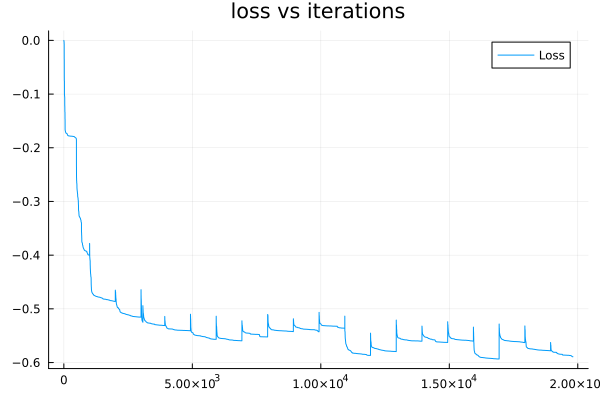

In [14]:
plot(losses, label = "Loss", title = "loss vs iterations") #, yscale = :log10)


In [15]:
losses

config[:tmax]

2.0

In [16]:
NN = create_chain(config)

Chain(
    layer_1 = Dense(2 => 20, tanh),               # 60 parameters
    layer_(2-4) = Dense(20 => 20, tanh),          # 1_260 (420 x 3) parameters
    layer_5 = Dense(20 => 1),                     # 21 parameters
)         # Total: 1_341 parameters,
          #        plus 0 states.

For the initial data with $u_1(x) = \partial_x u_0(x)$ the solution is:

$$ 
u(x,t) = 
\begin{cases}
& u_0(x+t) \;\;\;\; t \leq x \;\;\text{and} \;\;  t \leq 1 - x \\
& u_0(x+t) - u_0(x-t) \;\;\;\;\; t \geq x \;\; \text{and} \;\; t \leq 1 - x \\
& 0 \;\;\;\;\; t \leq x \;\; \text{and} \;\; t \geq 1 - x \\
& - u_0(x-t) \;\;\;\;\; t \geq x \;\; \text{and} \;\; t \geq 1 - x ;\; \text{and} \;\; t \leq 1 + x \\
\end{cases} 
$$

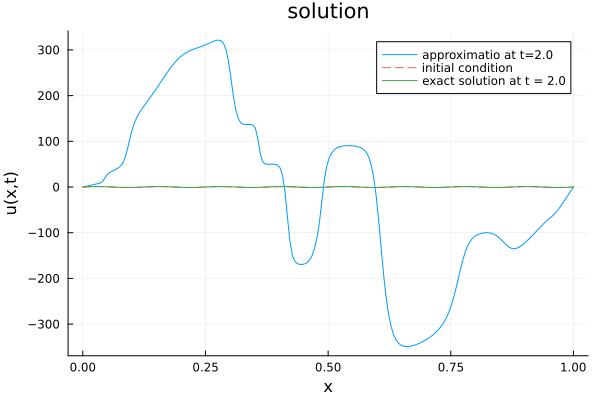

In [17]:
#@unpack xmin, xmax, A, B, p = config
t = 2.
xs = reshape(collect(range(config[:xmin], config[:xmax], length=200)), 1, :)
t_fix = reshape(fill(t, length(xs)), 1, :)
#sol_p = [calculate_Dirichlet_f(xs, t_fix, NN, Θ, st) for x in xs]
sol_p = [calculate_Dirichlet_f_wf(xs[:,i], t_fix[:,i], NN, Θ_cpu, st)[1] for i in 1:length(xs[1,:])]

plot(xs[1,:],sol_p, label = "approximatio at t=$t", title = "solution")
#lines!(xs[1,:],bump.(xs[1,:], config[:x0], config[:x1], config[:p], config[:A]), label = "initial condition")
plot!(xs[1,:],u0(xs[1,:]), label = "initial condition", linestyle = :dash)  
plot!(xlabel = "x", ylabel = "u(x,t)")   
plot!(xs[1,:], A*(sin.(2π*(xs[1,:].+t)*p/(xmax - xmin)) + sin.(2π*(xs[1,:].-t)*p/(xmax - xmin)))/2, label = "exact solution at t = $t")  # exact solution at t=2.0


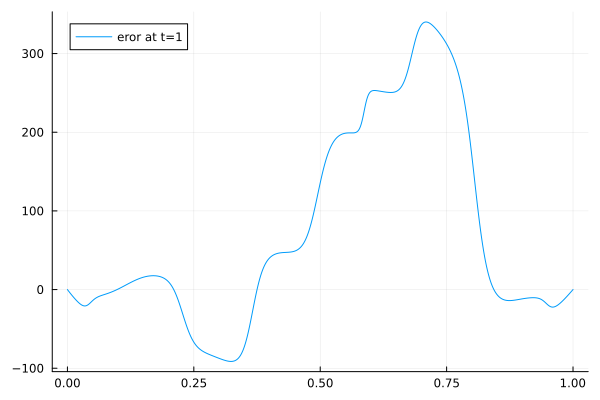

In [19]:
ax = (title = "solution")
t = 1.0
xs = reshape(collect(range(config[:xmin], config[:xmax], length=20000)), 1, :)
t_fix = reshape(fill(t, length(xs)), 1, :)
sol_p = [calculate_Dirichlet_f_wf(xs[:,i], t_fix[:,i], NN, Θ_cpu, st)[1] for i in 1:length(xs[1,:])]

plot(xs[1,:],sol_p .+ u0.(xs[1,:]), label = "eror at t=1")